In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, Bidirectional

import warnings
warnings.filterwarnings('ignore')

In [2]:
import ShapTimeRNN
from ShapTimeRNN import supertime, ShapleyValues, TimeImportance, TimeHeatmap, trans, supertime_add

In [3]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Solar_data.csv')
data.head()

,DATE_TIME,DAILY_YIELD,lag_1,lag_2,lag_DY,Month,Day,Hour,Minute,Weekday
0,2020/5/17 5:00,0.0,0.0,0.0,0.0,0,0.533333,0.217391,0.000000,1.0
1,2020/5/17 5:15,0.0,0.0,0.0,0.0,0,0.533333,0.217391,0.333333,1.0
2,2020/5/17 5:30,0.0,0.0,0.0,0.0,0,0.533333,0.217391,0.666667,1.0
3,2020/5/17 5:45,0.0,0.0,0.0,0.0,0,0.533333,0.217391,1.000000,1.0
4,2020/5/17 6:00,0.0,0.0,0.0,0.0,0,0.533333,0.260870,0.000000,1.0


In [4]:
train = data[:-192]
test = data[-192:]
print(train.shape)
print(test.shape)

(2734, 10)
(192, 10)


In [5]:
x_train = train.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_train = train.loc[:, ['DAILY_YIELD']]

x_test = test.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_test = test.loc[:, ['DAILY_YIELD']]

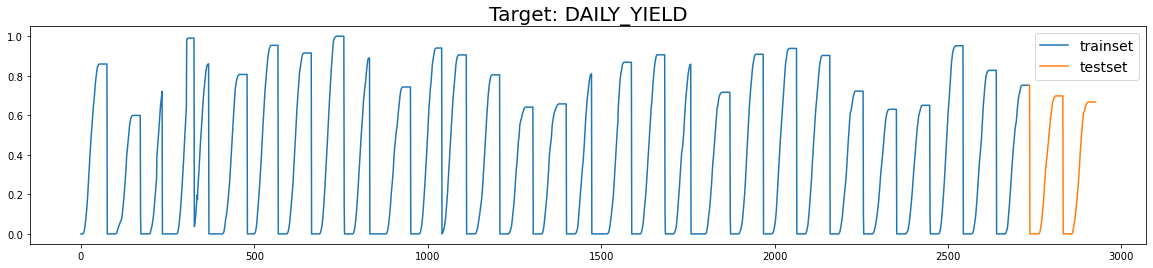

In [6]:
sns.reset_orig()
plt.figure(figsize = (20,4))
plt.title('Target: DAILY_YIELD', fontsize = 20)
plt.plot(y_train['DAILY_YIELD'], label = 'trainset')
plt.plot(y_test['DAILY_YIELD'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

In [7]:
x_train_sca = x_train.values[:].reshape(x_train.shape[0], 1, x_train.shape[1])
x_test_sca = x_test.values[:].reshape(x_test.shape[0], 1, x_test.shape[1])

# RNN

In [8]:
model_rnn = tf.keras.Sequential([
        SimpleRNN(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        SimpleRNN(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])

model_rnn.compile(loss='mse', optimizer='adam') 
    
history = model_rnn.fit(x_train_sca, y_train, batch_size=128, epochs=50)

Epoch 1/50
22/22 [==============================] - 1s 2ms/step - loss: 0.0887
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0514
Epoch 3/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0478
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0434
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0411
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0389
Epoch 7/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 8/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 9/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 10/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 11/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0345
Epoch 12/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0343
Epoch 13/50
22/22 [==============================

In [9]:
prediction_rnn = model_rnn.predict(x_test_sca)

6/6 [==============================] - 0s 897us/step


In [10]:
r2 = r2_score(prediction_rnn, y_test)
mse = mean_squared_error(prediction_rnn, y_test)
print(r2)
print(mse)

0.9587330852005056
0.005129075898049773


In [20]:
model_rnn.save('model_rnn.h5')

In [11]:
Tn= 10
interp_x= x_train_sca
model = model_rnn

ShapTime_rnn = ShapleyValues(model, interp_x, Tn)

35/35 [==============================] - 0s 588us/step


60/60 [==============================] - 0s 561us/step


43/43 [==============================] - 0s 560us/step


43/43 [==============================] - 0s 594us/step


69/69 [==============================] - 0s 564us/step


86/86 [==============================] - 0s 559us/step


In [12]:
ShapTime_rnn

[array([-0.01961912], dtype=float32),
 array([0.01341724], dtype=float32),
 array([0.0101425], dtype=float32),
 array([-0.0016459], dtype=float32),
 array([0.00127264], dtype=float32),
 array([-0.02163357], dtype=float32),
 array([-0.0103986], dtype=float32),
 array([0.01383172], dtype=float32),
 array([0.00254872], dtype=float32),
 array([0.01265329], dtype=float32)]

In [13]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

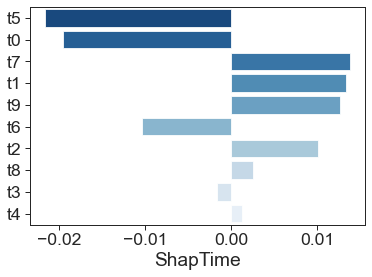

In [14]:
TimeImportance(Tn, trans(ShapTime_rnn), time_columns)

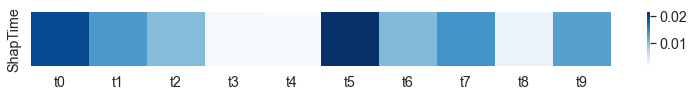

In [15]:
TimeHeatmap(Tn, trans(ShapTime_rnn), time_columns)

In [16]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [17]:
check_replist = [t0, t1, t2, t3, t5, t5, t6, t7, t8, t9] 

In [18]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_check = check.loc[:, ['DAILY_YIELD']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        SimpleRNN(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        SimpleRNN(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])

model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=128, epochs=50)

Epoch 1/50
22/22 [==============================] - 1s 2ms/step - loss: 0.0856
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0565
Epoch 3/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0497
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0447
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0434
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0408
Epoch 7/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0404
Epoch 8/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0394
Epoch 9/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 10/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0368
Epoch 11/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0352
Epoch 12/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0339
Epoch 13/50
22/22 [==============================

In [19]:
pred_check = model_check.predict(x_test_sca)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 971us/step
0.9701878498328984 Degree of Improvement: 1.19%
0.0024651422236962504 Degree of Improvement: 51.94%


In [21]:
model_check.save('model_(rnn).h5')

# LSTM

In [32]:
model_lstm = tf.keras.Sequential([
        LSTM(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        LSTM(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])

model_lstm.compile(loss='mse', optimizer='adam') 
    
history = model_lstm.fit(x_train_sca, y_train, batch_size=128, epochs=50)

Epoch 1/50
22/22 [==============================] - 2s 6ms/step - loss: 0.1961
Epoch 2/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0963
Epoch 3/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0740
Epoch 4/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0568
Epoch 5/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0481
Epoch 6/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0432
Epoch 7/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0401
Epoch 8/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 9/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0361
Epoch 10/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 11/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0345
Epoch 12/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0347
Epoch 13/50
22/22 [==============================

In [33]:
prediction_lstm = model_lstm.predict(x_test_sca)

6/6 [==============================] - 0s 2ms/step


In [34]:
r2 = r2_score(prediction_lstm, y_test)
mse = mean_squared_error(prediction_lstm, y_test)
print(r2)
print(mse)

0.9543989303518641
0.00569957431635344


In [44]:
model_lstm.save('model_lstm.h5')

In [35]:
Tn= 10
interp_x= x_train_sca
model = model_lstm

ShapTime_lstm = ShapleyValues(model, interp_x, Tn)

35/35 [==============================] - 0s 795us/step


43/43 [==============================] - 0s 795us/step


69/69 [==============================] - 0s 1ms/step


86/86 [==============================] - 0s 989us/step


In [36]:
ShapTime_lstm

[array([-0.01450435], dtype=float32),
 array([0.01282039], dtype=float32),
 array([-0.0006646], dtype=float32),
 array([0.00274064], dtype=float32),
 array([0.00359964], dtype=float32),
 array([-0.02105962], dtype=float32),
 array([-0.00676289], dtype=float32),
 array([0.01059939], dtype=float32),
 array([-0.00316304], dtype=float32),
 array([0.01687437], dtype=float32)]

In [37]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

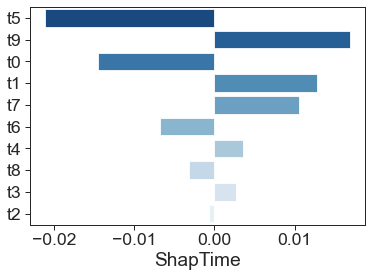

In [38]:
TimeImportance(Tn, trans(ShapTime_lstm), time_columns)

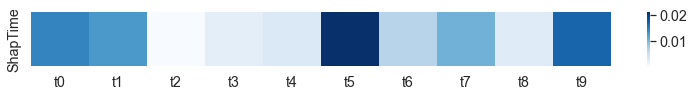

In [39]:
TimeHeatmap(Tn, trans(ShapTime_lstm), time_columns)

In [40]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [41]:
check_replist = [t0, t1, t5, t3, t4, t5, t6, t7, t8, t9] 

In [42]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_check = check.loc[:, ['DAILY_YIELD']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        LSTM(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        LSTM(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])


model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=128, epochs=50)

Epoch 1/50
22/22 [==============================] - 3s 13ms/step - loss: 0.2018
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 0.1019
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0787
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0582
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0477
Epoch 6/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0421
Epoch 7/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0397
Epoch 8/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0368
Epoch 9/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0358
Epoch 10/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0347
Epoch 11/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0350
Epoch 12/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0340
Epoch 13/50
22/22 [==================

In [43]:
pred_check = model_check.predict(x_test_sca)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 2ms/step
0.95975068170981 Degree of Improvement: 0.56%
0.004775266297081467 Degree of Improvement: 16.22%


In [45]:
model_check.save('model_(lstm).h5')

# GRU

In [8]:
model_gru = tf.keras.Sequential([
        GRU(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        GRU(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])

model_gru.compile(loss='mse', optimizer='adam') 
    
history = model_gru.fit(x_train_sca, y_train, batch_size=128, epochs=50)

Epoch 1/50
22/22 [==============================] - 3s 3ms/step - loss: 0.1398
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0800
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0522
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0448
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0411
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0380
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0367
Epoch 8/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0366
Epoch 9/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 10/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0352
Epoch 11/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0341
Epoch 12/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0321
Epoch 13/50
22/22 [==============================

In [9]:
prediction_gru = model_gru.predict(x_test_sca)

6/6 [==============================] - 0s 998us/step


In [10]:
r2 = r2_score(prediction_gru, y_test)
mse = mean_squared_error(prediction_gru, y_test)
print(r2)
print(mse)

0.9661852805810972
0.0034929017505517224


In [20]:
model_gru.save('model_gru.h5')

In [11]:
Tn= 10
interp_x= x_train_sca
model = model_gru

ShapTime_gru = ShapleyValues(model, interp_x, Tn)

35/35 [==============================] - 0s 683us/step


60/60 [==============================] - 0s 706us/step


43/43 [==============================] - 0s 714us/step


43/43 [==============================] - 0s 855us/step


86/86 [==============================] - 0s 730us/step


In [12]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

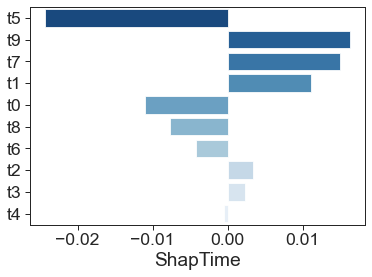

In [13]:
TimeImportance(Tn, trans(ShapTime_gru), time_columns)

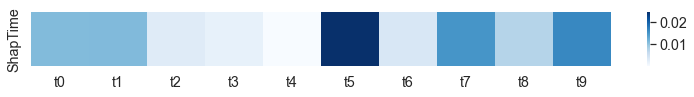

In [14]:
TimeHeatmap(Tn, trans(ShapTime_gru), time_columns)

In [16]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [17]:
check_replist = [t0, t1, t2, t3, t5, t5, t6, t7, t8, t9] 

In [18]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_check = check.loc[:, ['DAILY_YIELD']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        GRU(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        GRU(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])


model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=128, epochs=50)

Epoch 1/50
22/22 [==============================] - 2s 3ms/step - loss: 0.1430
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0762
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0538
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0466
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0430
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0418
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0392
Epoch 8/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0389
Epoch 9/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0380
Epoch 10/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0367
Epoch 11/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0357
Epoch 12/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0361
Epoch 13/50
22/22 [==============================

In [19]:
pred_check = model_check.predict(x_test_sca)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 996us/step
0.9740363608423397 Degree of Improvement: 0.81%
0.0026257578463872847 Degree of Improvement: 24.83%


In [21]:
model_check.save('model_(gru).h5')

# Bi-RNN

In [28]:
model_birnn = tf.keras.Sequential([
        Bidirectional(SimpleRNN(100, return_sequences=True,activation='relu')),
        Dropout(0.1),
        Dense(1) ])

model_birnn.compile(loss='mse', optimizer='adam') 
    
history = model_birnn.fit(x_train_sca, y_train, batch_size=128, epochs=50)

Epoch 1/50
22/22 [==============================] - 1s 1ms/step - loss: 0.0986
Epoch 2/50
22/22 [==============================] - 0s 1ms/step - loss: 0.0589
Epoch 3/50
22/22 [==============================] - 0s 965us/step - loss: 0.0472
Epoch 4/50
22/22 [==============================] - 0s 1ms/step - loss: 0.0436
Epoch 5/50
22/22 [==============================] - 0s 1ms/step - loss: 0.0417
Epoch 6/50
22/22 [==============================] - 0s 888us/step - loss: 0.0403
Epoch 7/50
22/22 [==============================] - 0s 1ms/step - loss: 0.0392
Epoch 8/50
22/22 [==============================] - 0s 1ms/step - loss: 0.0385
Epoch 9/50
22/22 [==============================] - 0s 1ms/step - loss: 0.0367
Epoch 10/50
22/22 [==============================] - 0s 1ms/step - loss: 0.0374
Epoch 11/50
22/22 [==============================] - 0s 1ms/step - loss: 0.0362
Epoch 12/50
22/22 [==============================] - 0s 1ms/step - loss: 0.0351
Epoch 13/50
22/22 [==========================

In [29]:
prediction_birnn = model_birnn.predict(x_test_sca)

6/6 [==============================] - 0s 2ms/step


In [30]:
prediction_birnn = prediction_birnn.reshape(192, 1)

In [31]:
r2 = r2_score(prediction_birnn, y_test)
mse = mean_squared_error(prediction_birnn, y_test)
print(r2)
print(mse)

0.9312614213278525
0.00990734939234829


In [32]:
model_birnn.save('model_birnn.h5')

In [33]:
prediction_birnn = model_birnn.predict(x_test_sca)

6/6 [==============================] - 0s 798us/step


In [34]:
Tn= 10
interp_x= x_train_sca
model = model_birnn

ShapTime_birnn = ShapleyValues(model, interp_x, Tn)

35/35 [==============================] - 0s 580us/step


60/60 [==============================] - 0s 675us/step


43/43 [==============================] - 0s 677us/step


69/69 [==============================] - 0s 613us/step


86/86 [==============================] - 0s 690us/step


In [35]:
ShapTime_birnn

[array([[-0.01794069]], dtype=float32),
 array([[0.0109115]], dtype=float32),
 array([[0.00081593]], dtype=float32),
 array([[-0.00022194]], dtype=float32),
 array([[0.00328243]], dtype=float32),
 array([[-0.0192517]], dtype=float32),
 array([[-0.00862565]], dtype=float32),
 array([[0.01257395]], dtype=float32),
 array([[0.00060297]], dtype=float32),
 array([[0.01843788]], dtype=float32)]

In [36]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

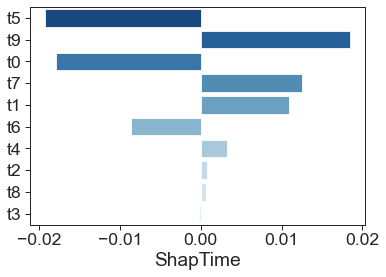

In [37]:
TimeImportance(Tn, trans(ShapTime_birnn), time_columns)

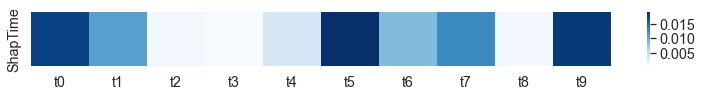

In [38]:
TimeHeatmap(Tn, trans(ShapTime_birnn), time_columns)

In [39]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [40]:
check_replist = [t0, t1, t2, t3, t5, t5, t6, t7, t8, t9] 

In [41]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_check = check.loc[:, ['DAILY_YIELD']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        Bidirectional(SimpleRNN(100, return_sequences=True,activation='relu')),
        Dropout(0.1),
        Dense(1) ])


model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=128, epochs=50)

Epoch 1/50
22/22 [==============================] - 1s 3ms/step - loss: 0.1405
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0683
Epoch 3/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0548
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0488
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0457
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0441
Epoch 7/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0426
Epoch 8/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 9/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0395
Epoch 10/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 11/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0384
Epoch 12/50
22/22 [==============================] - 0s 2ms/step - loss: 0.0380
Epoch 13/50
22/22 [==============================

In [42]:
pred_check = model_check.predict(x_test_sca)
pred_check = pred_check.reshape(192, 1)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 3ms/step
0.9693537933864437 Degree of Improvement: 4.09%
0.0036554175337295725 Degree of Improvement: 63.10%


In [43]:
model_check.save('model_(birnn).h5')

# Bi-LSTM

In [21]:
model_bilstm = tf.keras.Sequential([
        Bidirectional(LSTM(100, return_sequences=True,activation='relu')), 
        Dropout(0.2),
        Dense(1) ])

model_bilstm.compile(loss='mse', optimizer='adam') 
    
history = model_bilstm.fit(x_train_sca, y_train, batch_size=64, epochs=100)

Epoch 1/100
43/43 [==============================] - 2s 2ms/step - loss: 0.1540
Epoch 2/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0723
Epoch 3/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0489
Epoch 4/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0412
Epoch 5/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 6/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0361
Epoch 7/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0345
Epoch 8/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0342
Epoch 9/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 10/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 11/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0323
Epoch 12/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0323
Epoch 13/100
43/43 [=================

In [22]:
prediction_bilstm = model_bilstm.predict(x_test_sca)
prediction_bilstm = prediction_bilstm.reshape(192, 1)

6/6 [==============================] - 0s 998us/step


In [23]:
r2 = r2_score(prediction_bilstm, y_test)
mse = mean_squared_error(prediction_bilstm, y_test)
print(r2)
print(mse)

0.9326012508084868
0.00823322077964827


In [34]:
model_bilstm.save('model_bilstm.h5')

In [24]:
Tn= 10
interp_x= x_train_sca
model = model_bilstm

ShapTime_bilstm = ShapleyValues(model, interp_x, Tn)

35/35 [==============================] - 0s 675us/step


60/60 [==============================] - 0s 659us/step


43/43 [==============================] - 0s 689us/step


69/69 [==============================] - 0s 687us/step


86/86 [==============================] - 0s 704us/step


In [25]:
ShapTime_bilstm

[array([[-0.02242166]], dtype=float32),
 array([[0.00908568]], dtype=float32),
 array([[0.0049721]], dtype=float32),
 array([[0.00279756]], dtype=float32),
 array([[-0.00045401]], dtype=float32),
 array([[-0.02166052]], dtype=float32),
 array([[-0.00722344]], dtype=float32),
 array([[0.01737268]], dtype=float32),
 array([[0.00172131]], dtype=float32),
 array([[0.0163502]], dtype=float32)]

In [26]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

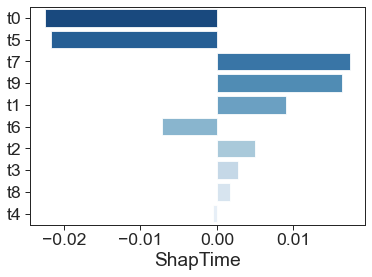

In [27]:
TimeImportance(Tn, trans(ShapTime_bilstm), time_columns)

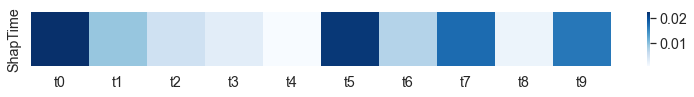

In [28]:
TimeHeatmap(Tn, trans(ShapTime_bilstm), time_columns)

In [29]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [30]:
check_replist = [t0, t1, t2, t3, t0, t5, t6, t7, t8, t9] 

In [31]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_check = check.loc[:, ['DAILY_YIELD']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        Bidirectional(LSTM(100, return_sequences=True,activation='relu')), 
        Dropout(0.2),
        Dense(1) ])


model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=64, epochs=100)

Epoch 1/100
43/43 [==============================] - 2s 4ms/step - loss: 0.1242
Epoch 2/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0656
Epoch 3/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0494
Epoch 4/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0434
Epoch 5/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0403
Epoch 6/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0383
Epoch 7/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0363
Epoch 8/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0360
Epoch 9/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0350
Epoch 10/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0338
Epoch 11/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0335
Epoch 12/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0329
Epoch 13/100
43/43 [=================

In [33]:
pred_check = model_check.predict(x_test_sca)
pred_check = pred_check.reshape(192, 1)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 1ms/step
0.9742884845924012 Degree of Improvement: 4.47%
0.0028190206831359547 Degree of Improvement: 65.76%


In [35]:
model_check.save('model_(bilstm).h5')

# Bi-GRU

In [8]:
model_bigru = tf.keras.Sequential([
        Bidirectional(GRU(100, return_sequences=True,activation='relu')), 
        Dropout(0.1),
        Bidirectional(GRU(100, return_sequences=True,activation='relu')),
        Dropout(0.2),
        Dense(1) ])

model_bigru.compile(loss='mse', optimizer='adam') 
    
history = model_bigru.fit(x_train_sca, y_train, batch_size=64, epochs=100)

Epoch 1/100
43/43 [==============================] - 4s 3ms/step - loss: 0.1016
Epoch 2/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0392
Epoch 3/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 4/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0323
Epoch 5/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0311
Epoch 6/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0290
Epoch 7/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0288
Epoch 8/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0283
Epoch 9/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 10/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 11/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 12/100
43/43 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch 13/100
43/43 [=================

In [9]:
prediction_bigru = model_bigru.predict(x_test_sca)
prediction_bigru = prediction_bigru.reshape(192, 1)

6/6 [==============================] - 0s 1ms/step


In [10]:
r2 = r2_score(prediction_bigru, y_test)
mse = mean_squared_error(prediction_bigru, y_test)
print(r2)
print(mse)

0.9481219938335195
0.005657595124010765


In [20]:
model_bigru.save('model_bigru.h5')

In [11]:
Tn= 10
interp_x= x_train_sca
model = model_bigru

ShapTime_bigru = ShapleyValues(model, interp_x, Tn)

35/35 [==============================] - 0s 871us/step


43/43 [==============================] - 0s 902us/step


43/43 [==============================] - 0s 1ms/step


86/86 [==============================] - 0s 1ms/step


In [12]:
ShapTime_bigru

[array([[-0.03137738]], dtype=float32),
 array([[0.00810831]], dtype=float32),
 array([[0.01682219]], dtype=float32),
 array([[0.00291628]], dtype=float32),
 array([[-0.00739976]], dtype=float32),
 array([[-0.01511583]], dtype=float32),
 array([[-0.00753246]], dtype=float32),
 array([[0.02468211]], dtype=float32),
 array([[-0.00714557]], dtype=float32),
 array([[0.01658694]], dtype=float32)]

In [13]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

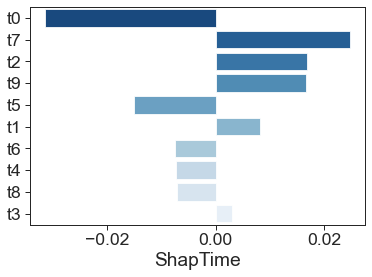

In [14]:
TimeImportance(Tn, trans(ShapTime_bigru), time_columns)

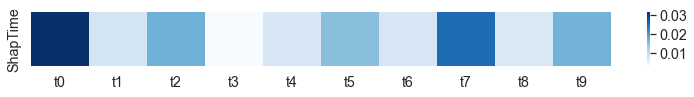

In [15]:
TimeHeatmap(Tn, trans(ShapTime_bigru), time_columns)

In [16]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [17]:
check_replist = [t0, t1, t2, t0, t4, t5, t6, t7, t8, t9] 

In [18]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_check = check.loc[:, ['DAILY_YIELD']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        Bidirectional(GRU(100, return_sequences=True,activation='relu')), 
        Dropout(0.1),
        Bidirectional(GRU(100, return_sequences=True,activation='relu')),
        Dropout(0.2),
        Dense(1) ])


model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=64, epochs=100)

Epoch 1/100
43/43 [==============================] - 4s 4ms/step - loss: 0.0975
Epoch 2/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0391
Epoch 3/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0330
Epoch 4/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0305
Epoch 5/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0283
Epoch 6/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0271
Epoch 7/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0258
Epoch 8/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0258
Epoch 9/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0240
Epoch 10/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 11/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 12/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0204
Epoch 13/100
43/43 [=================

In [19]:
pred_check = model_check.predict(x_test_sca)
pred_check = pred_check.reshape(192, 1)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 2ms/step
0.984016986840869 Degree of Improvement: 3.79%
0.0014780944640385059 Degree of Improvement: 73.87%


In [21]:
model_check.save('model_(bigru).h5')